In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
# Parameters for calculations
nodeA_id = 1
nodeB_id = 2
broadcast_time = list(np.arange(0.5, 20.5, 0.5)) #seconds
# broadcast_time = list(np.arange(0.5, 1, 0.5)) #seconds
log_position_time = 0.1 #seconds
window_time_threshold = 5
sim_time = 2 #minutes
sim_time_seg = sim_time*60
results_path = f'../results/{sim_time}min'
broadcast_time

[0.5,
 1.0,
 1.5,
 2.0,
 2.5,
 3.0,
 3.5,
 4.0,
 4.5,
 5.0,
 5.5,
 6.0,
 6.5,
 7.0,
 7.5,
 8.0,
 8.5,
 9.0,
 9.5,
 10.0,
 10.5,
 11.0,
 11.5,
 12.0,
 12.5,
 13.0,
 13.5,
 14.0,
 14.5,
 15.0,
 15.5,
 16.0,
 16.5,
 17.0,
 17.5,
 18.0,
 18.5,
 19.0,
 19.5,
 20.0]

## Real Contact Time %

To calculate real contact time we use position files

In [3]:
avg_sum = 0
avg_total_time = 0

for bt in broadcast_time:
    nodeA_pos_file_name = f'{results_path}/n{nodeA_id}_{window_time_threshold:.2f}wt-{bt:.2f}bt-{log_position_time:.2f}lp_position.csv'
    nodeB_pos_file_name = f'{results_path}/n{nodeB_id}_{window_time_threshold:.2f}wt-{bt:.2f}bt-{log_position_time:.2f}lp_position.csv'

    position_file_header = ['node_A', 'timestamp_A', 'x_pos_A', 'y_pos_A']
    nodeA_pos = pd.read_csv(nodeA_pos_file_name, names=position_file_header)
    position_file_header = ['node_B', 'timestamp_B', 'x_pos_B', 'y_pos_B']
    nodeB_pos = pd.read_csv(nodeB_pos_file_name, names=position_file_header)


    df_pos = pd.concat([nodeA_pos, nodeB_pos], axis=1)
    df_pos['distance'] = (np.sqrt(np.power(df_pos.x_pos_A-df_pos.x_pos_B, 2)+np.power(df_pos.y_pos_A-df_pos.y_pos_B, 2)))<2.0

    adj_check = (df_pos.distance != df_pos.distance.shift()).cumsum()
    time = df_pos.groupby(['node_A','distance', adj_check], as_index=False, sort=False)['distance'].sum()*0.1

    real_contact_time = time.groupby('node_A').sum().iloc[0][0]
    avg_sum += real_contact_time
    avg_total_time = real_contact_time if real_contact_time>avg_total_time else avg_total_time

# avg_total_time = avg_sum/len(broadcast_time)
avg_total_time/=sim_time_seg
# avg_total_time*=100
print(avg_total_time)

0.4058333333333334


## Estimated Contact Time %

Contact time estimated with the protocol, plot compared to real contact time

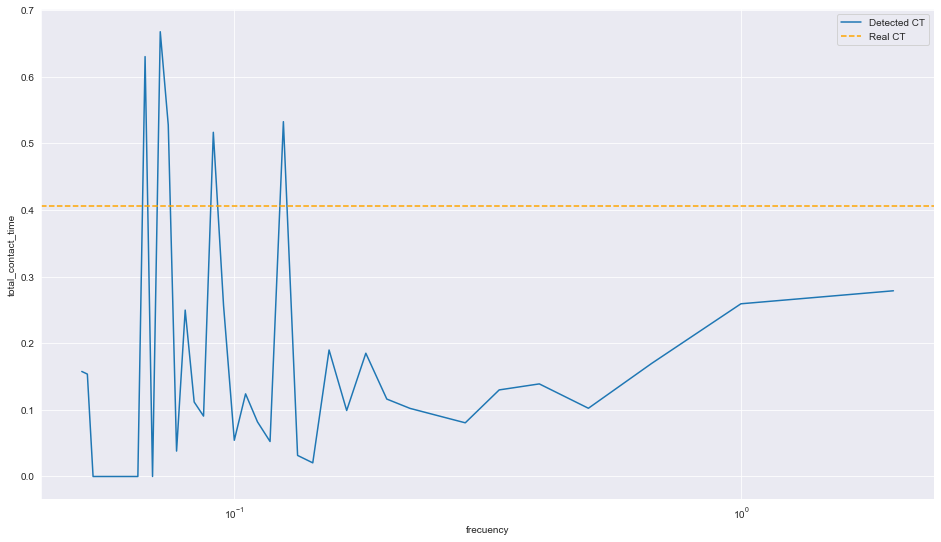

In [4]:
# Dataframe preparation
result_file_header = ["node", "broadcast_time", "seen_id", "told_by", "hop", "start", "end"]
nodeA_res = pd.DataFrame()

for bt in broadcast_time:
    nodeA_res_file_name = f'{results_path}/n{nodeA_id}_{window_time_threshold:.2f}wt-{bt:.2f}bt-{log_position_time:.2f}lp_results.csv'
    # nodeB_res_file_name = f'{results_path}/n{nodeB_id}_{window_time_threshold}wt-{bt}bt-{log_position_time}lp_results.csv'
    df = pd.read_csv(nodeA_res_file_name, names=result_file_header)
    df["total_contact_time"] = df["end"]-df["start"]
    df["broadcast_time"] = bt
    nodeA_res = pd.concat([nodeA_res, df])
    # nodeB_res = pd.read_csv(nodeB_res_file_name, names=result_file_header)
    # df = pd.concat([nodeA_res, nodeB_res], ignore_index=True)
# nodeA_res
nodeA_res.drop(["told_by", "hop", "start", "end"], axis=1).groupby(["node", "seen_id", "broadcast_time"], as_index=False).sum()
#     # total_contact_time = pd.concat([total_contact_time, df], ignore_index=True)
total_contact_time = nodeA_res.drop(["told_by", "hop", "start", "end"], axis=1).groupby(["node", "seen_id", "broadcast_time"], as_index=False).sum()
# total_contact_time.total_contact_time.broadcast_time = total_contact_time.total_contact_time/sim_time_seg
total_contact_time.total_contact_time = total_contact_time.total_contact_time/sim_time_seg
total_contact_time["frecuency"] = 1/total_contact_time["broadcast_time"]
# # # # Plot
a4_dims = (16,9)
fig, ax = plt.subplots(figsize=a4_dims)
#
plot = sns.lineplot(x="frecuency", y="total_contact_time", data=total_contact_time[total_contact_time.node==1], ax=ax)
plot.set(xscale='log')
ax.axhline(avg_total_time, ls='--', color='orange')
ax.lines[0].set_label('Detected CT')
ax.lines[1].set_label('Real CT')
ax.legend()
plt.show()

## Window count: Real VS Estimated

<AxesSubplot:>

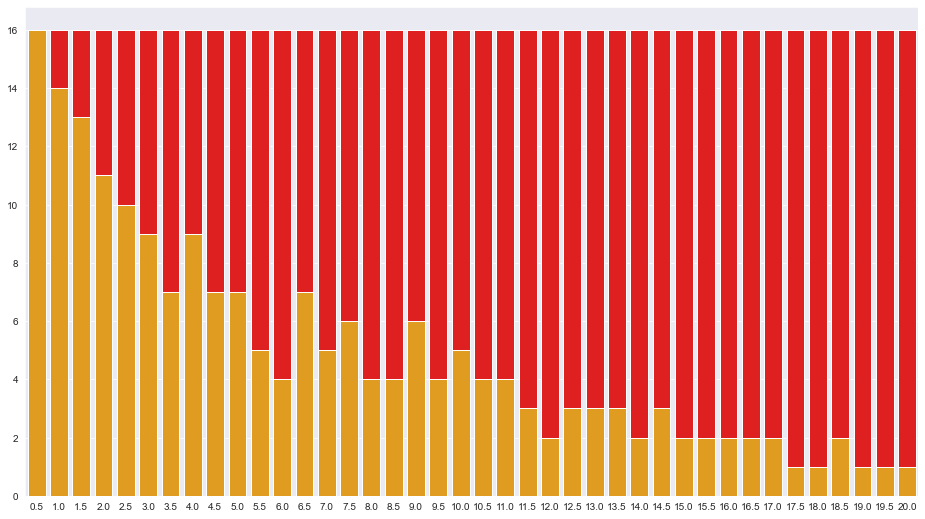

In [5]:
real = []
estimated = []
for bt in broadcast_time:
    nodeA_pos_file_name = f'{results_path}/n{nodeA_id}_{window_time_threshold:.2f}wt-{bt:.2f}bt-{log_position_time:.2f}lp_position.csv'
    nodeB_pos_file_name = f'{results_path}/n{nodeB_id}_{window_time_threshold:.2f}wt-{bt:.2f}bt-{log_position_time:.2f}lp_position.csv'

    position_file_header = ['node_A', 'timestamp_A', 'x_pos_A', 'y_pos_A']
    nodeA_pos = pd.read_csv(nodeA_pos_file_name, names=position_file_header)
    position_file_header = ['node_B', 'timestamp_B', 'x_pos_B', 'y_pos_B']
    nodeB_pos = pd.read_csv(nodeB_pos_file_name, names=position_file_header)

    nodeA_res_file_name = f'{results_path}/n{nodeA_id}_{window_time_threshold:.2f}wt-{bt:.2f}bt-{log_position_time:.2f}lp_results.csv'
    df = pd.read_csv(nodeA_res_file_name, names=result_file_header)


    df_pos = pd.concat([nodeA_pos, nodeB_pos], axis=1)
    df_pos['distance'] = (np.sqrt(np.power(df_pos.x_pos_A-df_pos.x_pos_B, 2)+np.power(df_pos.y_pos_A-df_pos.y_pos_B, 2)))<2.0

    adj_check = (df_pos.distance != df_pos.distance.shift()).cumsum()
    time = df_pos.groupby(['node_A','distance', adj_check], as_index=False, sort=False)['distance'].sum()*0.1
    real.append(np.count_nonzero(time.distance!=0))
    estimated.append(df.shape[0])

fig, ax = plt.subplots(figsize=a4_dims)
sns.barplot(x=np.array(broadcast_time), y=real, ax=ax, color='red')
sns.barplot(x=np.array(broadcast_time), y=estimated, ax=ax, color='orange')
# ax.set(xscale='log')0

## Accumulative Window Time VS Simulation Time

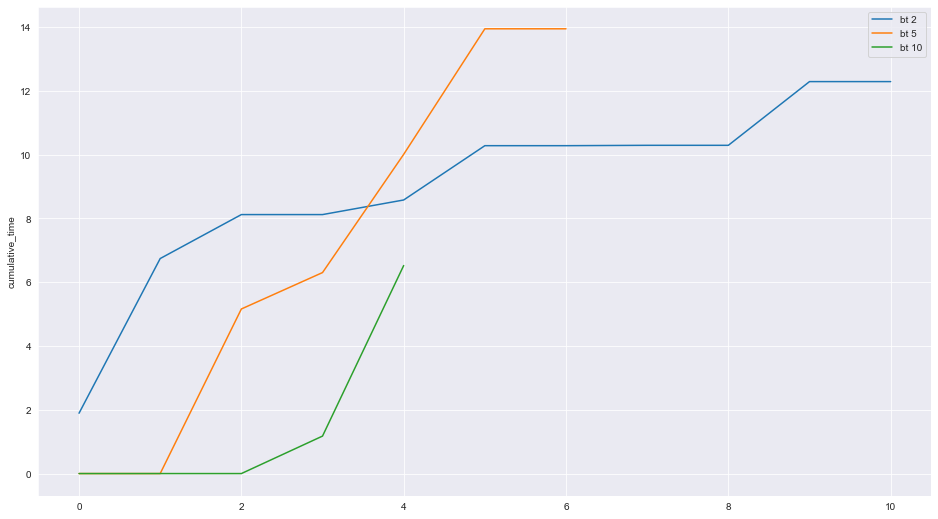

In [7]:
# for bt in broadcast_time:
a4_dims = (16,9)
fig, ax = plt.subplots(figsize=a4_dims)
broadcast_time = [ 2, 5, 10]
for bt in broadcast_time:
    nodeA_res_file_name = f'{results_path}/n{nodeA_id}_{window_time_threshold:.2f}wt-{bt:.2f}bt-{log_position_time:.2f}lp_results.csv'
    df = pd.read_csv(nodeA_res_file_name, names=result_file_header)
    df["total_contact_time"] = df["end"]-df["start"]
    df["cumulative_time"] = df.total_contact_time.cumsum()
    plot = sns.lineplot(x=np.arange(0, df.shape[0]), y=df.cumulative_time, ax=ax, label=f"bt {bt}")

ax.legend()
plt.show()